<a href="https://colab.research.google.com/github/yangyangeii/BigDataVisualization/blob/main/obesity_xai_pastel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4. Explainable AI (XAI) Modeling

**Author**: Lee Ji-hyun | **Date**: 2025-11-19

- n_estimators=128, Full dataset training/evaluation
- 5 XAI Methods: Feature Importance, Permutation, SHAP, LIME, PDP

In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn shap lime -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import shap
import lime.lime_tabular
import warnings
warnings.filterwarnings('ignore')

# Pastel color palette
PASTEL = {
    'pink': '#FFB6C1',
    'blue': '#87CEEB',
    'green': '#98D8AA',
    'purple': '#DDA0DD',
    'orange': '#FFDAB9',
    'yellow': '#FFFACD',
    'mint': '#B5EAD7',
    'lavender': '#E6E6FA',
    'peach': '#FFE5B4',
    'coral': '#FFB7B2'
}
COLORS = ['#FFB6C1', '#87CEEB', '#98D8AA', '#DDA0DD', '#FFDAB9', '#B5EAD7', '#E6E6FA', '#FFB7B2']

# High quality settings
plt.rcParams.update({
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.titleweight': 'bold',
    'axes.labelsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--'
})

print("Libraries loaded successfully")

Libraries loaded successfully


In [3]:
from google.colab import files
uploaded = files.upload()

Saving obesity_selected_30variables.csv to obesity_selected_30variables.csv


In [4]:
# Load and preprocess data
df = pd.read_csv('obesity_selected_30variables.csv')

target_col = 'NObeyesdad_label'
exclude_cols = ['KNN_pred', 'LR_pred', 'DT_pred', target_col]
feature_cols = [col for col in df.columns if col not in exclude_cols]

X = df[feature_cols].copy()
le = LabelEncoder()
y = le.fit_transform(df[target_col])
target_names = le.classes_

print(f"Data: {X.shape[0]} samples, {X.shape[1]} features, {len(target_names)} classes")

Data: 2111 samples, 26 features, 7 classes


## 4-1. Model Training

In [5]:
# Train model
rf_model = RandomForestClassifier(n_estimators=128, random_state=42)
rf_model.fit(X, y)
y_pred = rf_model.predict(X)
accuracy = accuracy_score(y, y_pred)

print(f"\n{'='*50}")
print(f"  Random Forest (n_estimators=128)")
print(f"  Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"{'='*50}")
print(classification_report(y, y_pred, target_names=target_names))


  Random Forest (n_estimators=128)
  Accuracy: 1.0000 (100.00%)
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      1.00      1.00       272
      Normal_Weight       1.00      1.00      1.00       287
     Obesity_Type_I       1.00      1.00      1.00       351
    Obesity_Type_II       1.00      1.00      1.00       297
   Obesity_Type_III       1.00      1.00      1.00       324
 Overweight_Level_I       1.00      1.00      1.00       290
Overweight_Level_II       1.00      1.00      1.00       290

           accuracy                           1.00      2111
          macro avg       1.00      1.00      1.00      2111
       weighted avg       1.00      1.00      1.00      2111



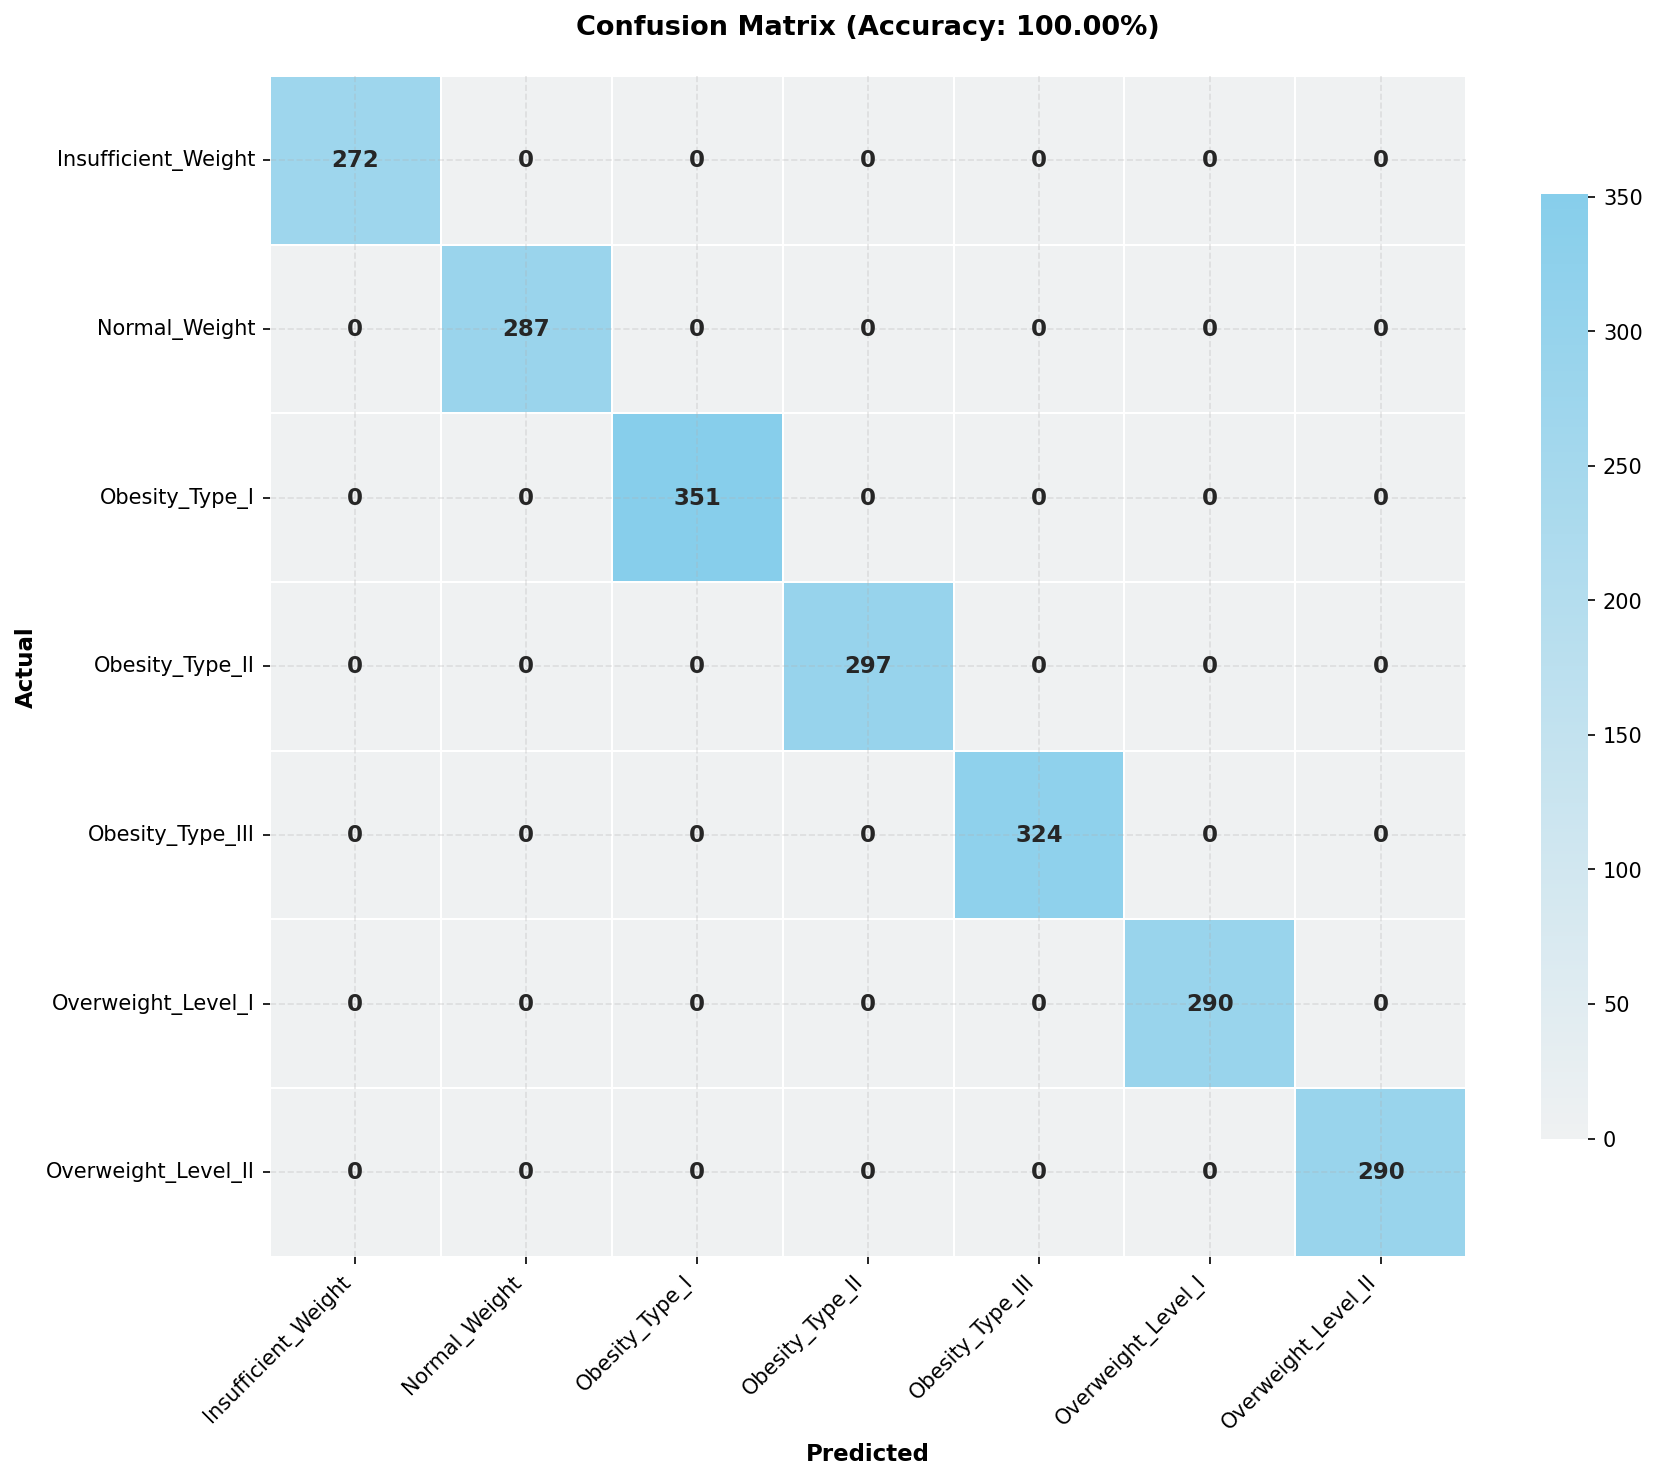

In [6]:
# Confusion Matrix
fig, ax = plt.subplots(figsize=(12, 10))
cm = confusion_matrix(y, y_pred)

# Pastel colormap
cmap = sns.light_palette(PASTEL['blue'], as_cmap=True)
sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
            xticklabels=target_names, yticklabels=target_names,
            linewidths=0.8, linecolor='white', ax=ax,
            annot_kws={'size': 11, 'weight': 'bold'},
            cbar_kws={'shrink': 0.8})
ax.set_title(f'Confusion Matrix (Accuracy: {accuracy:.2%})', pad=20)
ax.set_xlabel('Predicted', fontweight='bold')
ax.set_ylabel('Actual', fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 4-2. XAI Analysis (5 Methods)

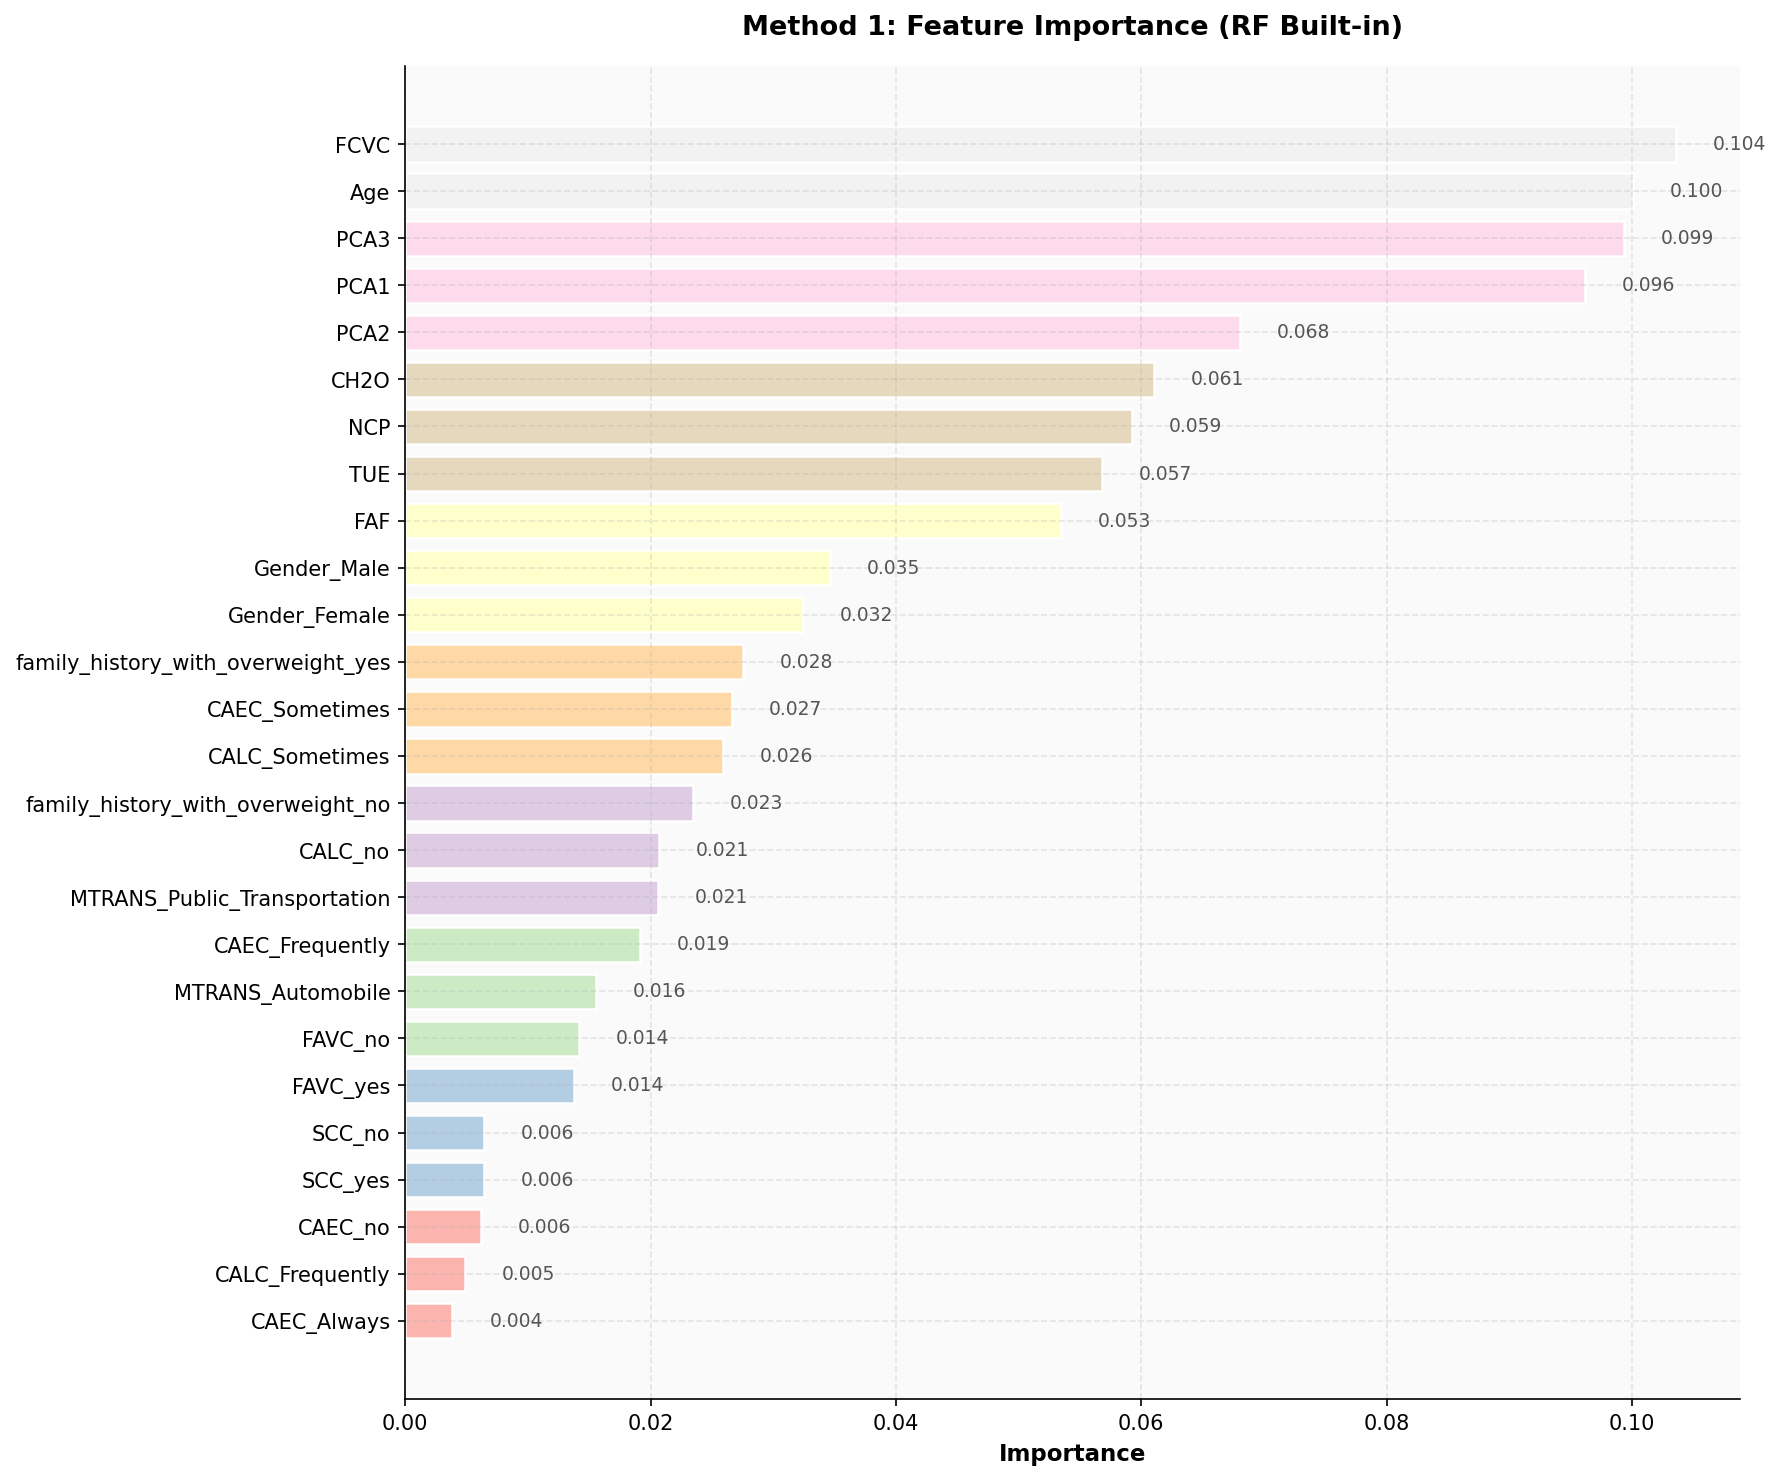

In [7]:
# Method 1: Feature Importance (RF Built-in)
feature_importance = pd.DataFrame({
    'Feature': X.columns, 'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=True)

fig, ax = plt.subplots(figsize=(12, 10))

# Pastel gradient
colors = [plt.cm.Pastel1(i/len(feature_importance)) for i in range(len(feature_importance))]
bars = ax.barh(feature_importance['Feature'], feature_importance['Importance'],
               color=colors, edgecolor='white', height=0.75, linewidth=1.2)

ax.set_xlabel('Importance', fontweight='bold')
ax.set_title('Method 1: Feature Importance (RF Built-in)', pad=15)
ax.spines[['top', 'right']].set_visible(False)
ax.set_facecolor('#FAFAFA')

for bar, val in zip(bars, feature_importance['Importance']):
    ax.text(val + 0.003, bar.get_y() + bar.get_height()/2, f'{val:.3f}',
            va='center', fontsize=9, color='#555555')

plt.tight_layout()
plt.show()

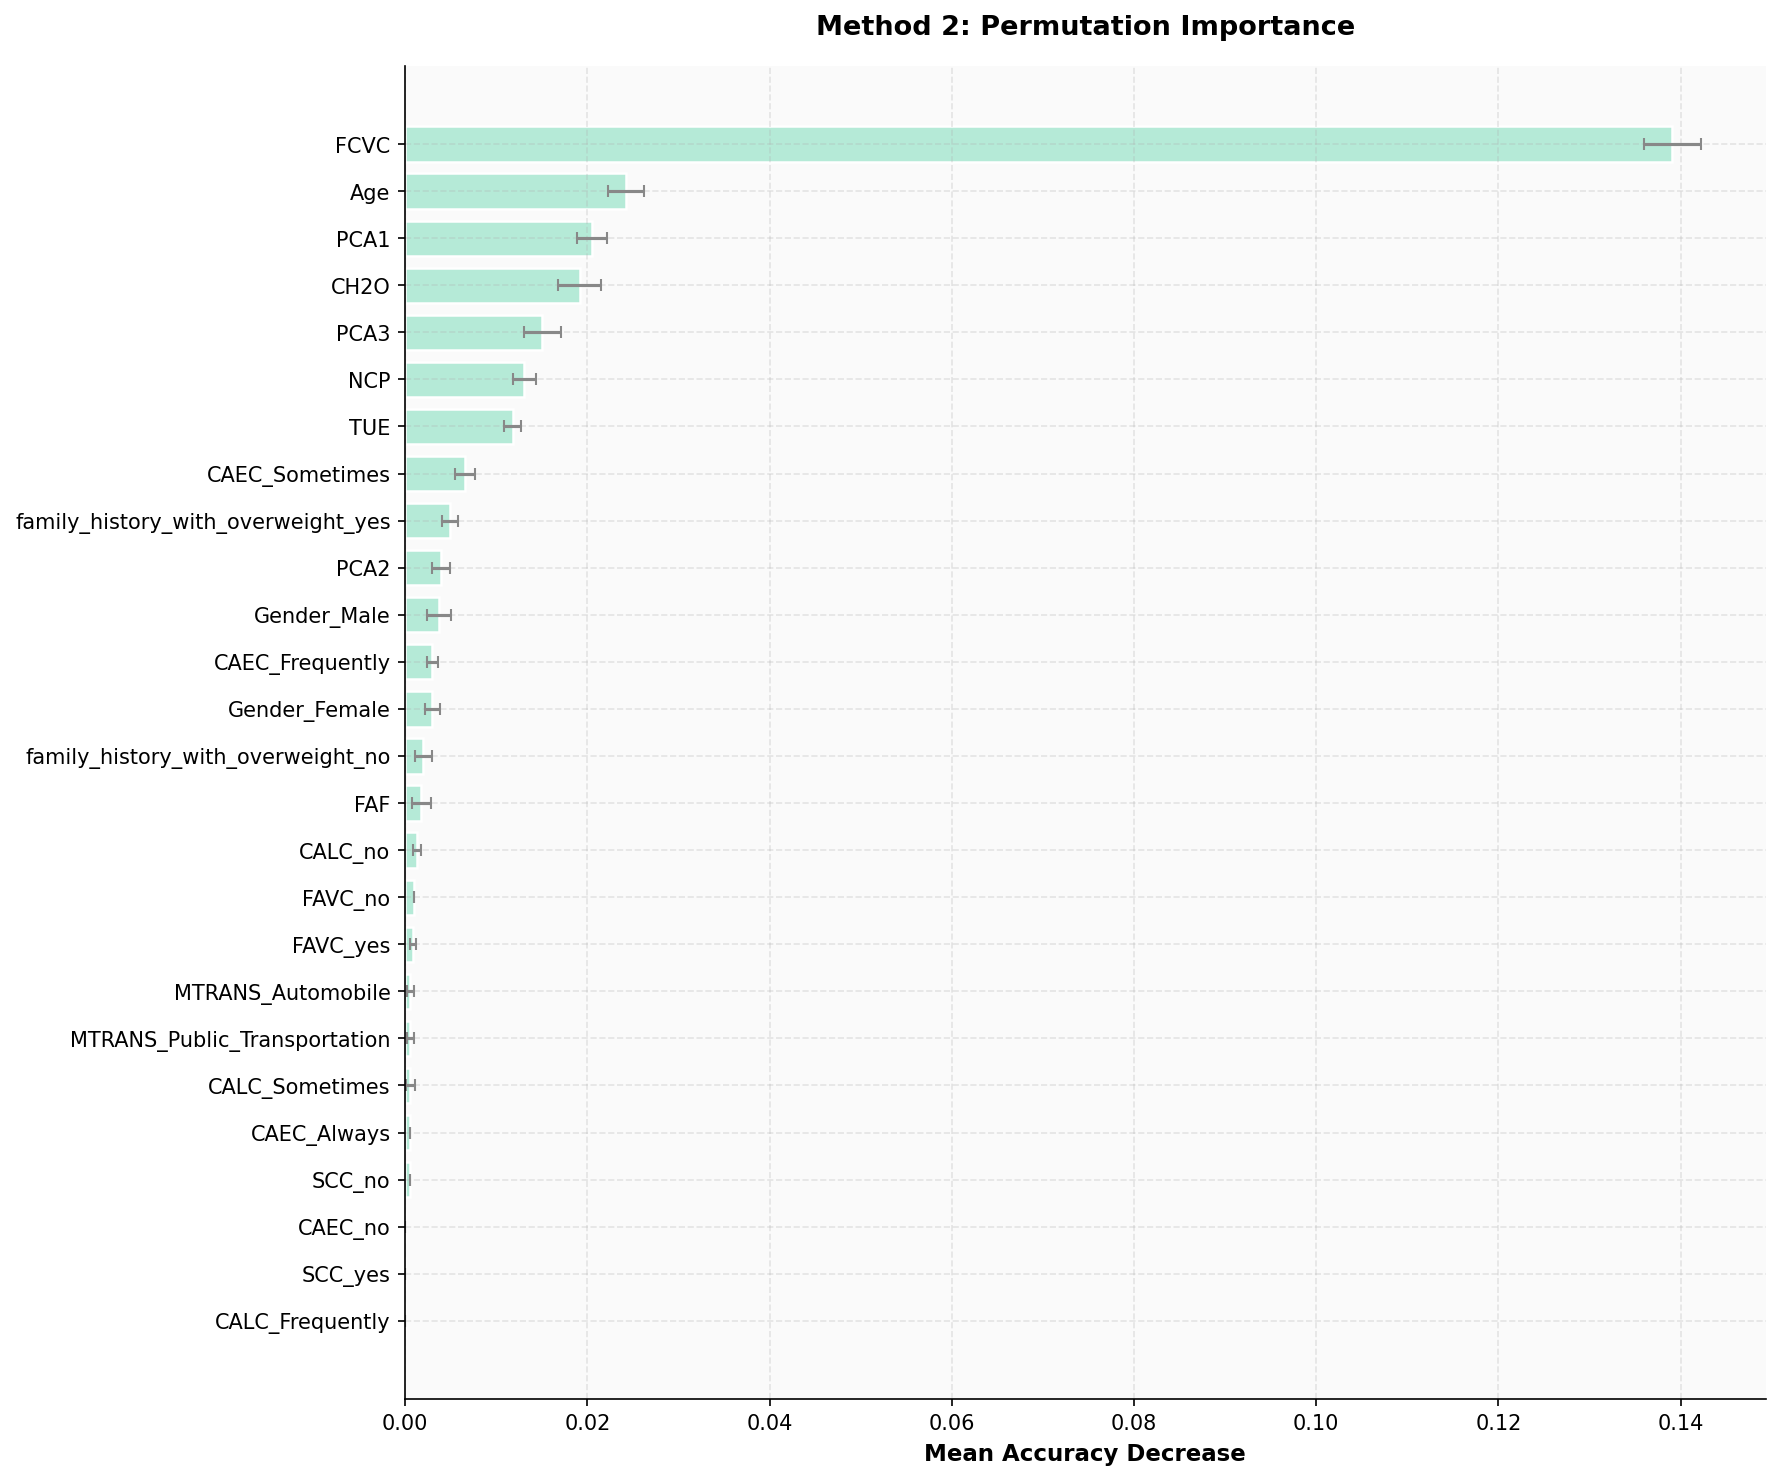

In [8]:
# Method 2: Permutation Importance
perm_result = permutation_importance(rf_model, X, y, n_repeats=10, random_state=42, n_jobs=-1)
perm_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_result.importances_mean,
    'Std': perm_result.importances_std
}).sort_values('Importance', ascending=True)

fig, ax = plt.subplots(figsize=(12, 10))

# Mint pastel gradient
colors = [plt.cm.Greens(0.3 + 0.5*i/len(perm_importance_df)) for i in range(len(perm_importance_df))]
ax.barh(perm_importance_df['Feature'], perm_importance_df['Importance'],
        xerr=perm_importance_df['Std'], color=PASTEL['mint'],
        edgecolor='white', height=0.75, capsize=3, linewidth=1.2,
        error_kw={'ecolor': '#888888', 'linewidth': 1.5})

ax.set_xlabel('Mean Accuracy Decrease', fontweight='bold')
ax.set_title('Method 2: Permutation Importance', pad=15)
ax.spines[['top', 'right']].set_visible(False)
ax.set_facecolor('#FAFAFA')

plt.tight_layout()
plt.show()

In [9]:
# Method 3: SHAP
X_sample = X.sample(n=min(500, len(X)), random_state=42)
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer(X_sample)

# Calculate SHAP importance
shap_importance_values = np.abs(shap_values.values).mean(axis=0)

# Multi-class: average across classes
if len(shap_importance_values.shape) > 1:
    shap_importance_values = shap_importance_values.mean(axis=1)

shap_importance = pd.DataFrame({
    'Feature': X.columns,
    'SHAP': shap_importance_values
}).sort_values('SHAP', ascending=False)

print("SHAP values calculated successfully")

SHAP values calculated successfully


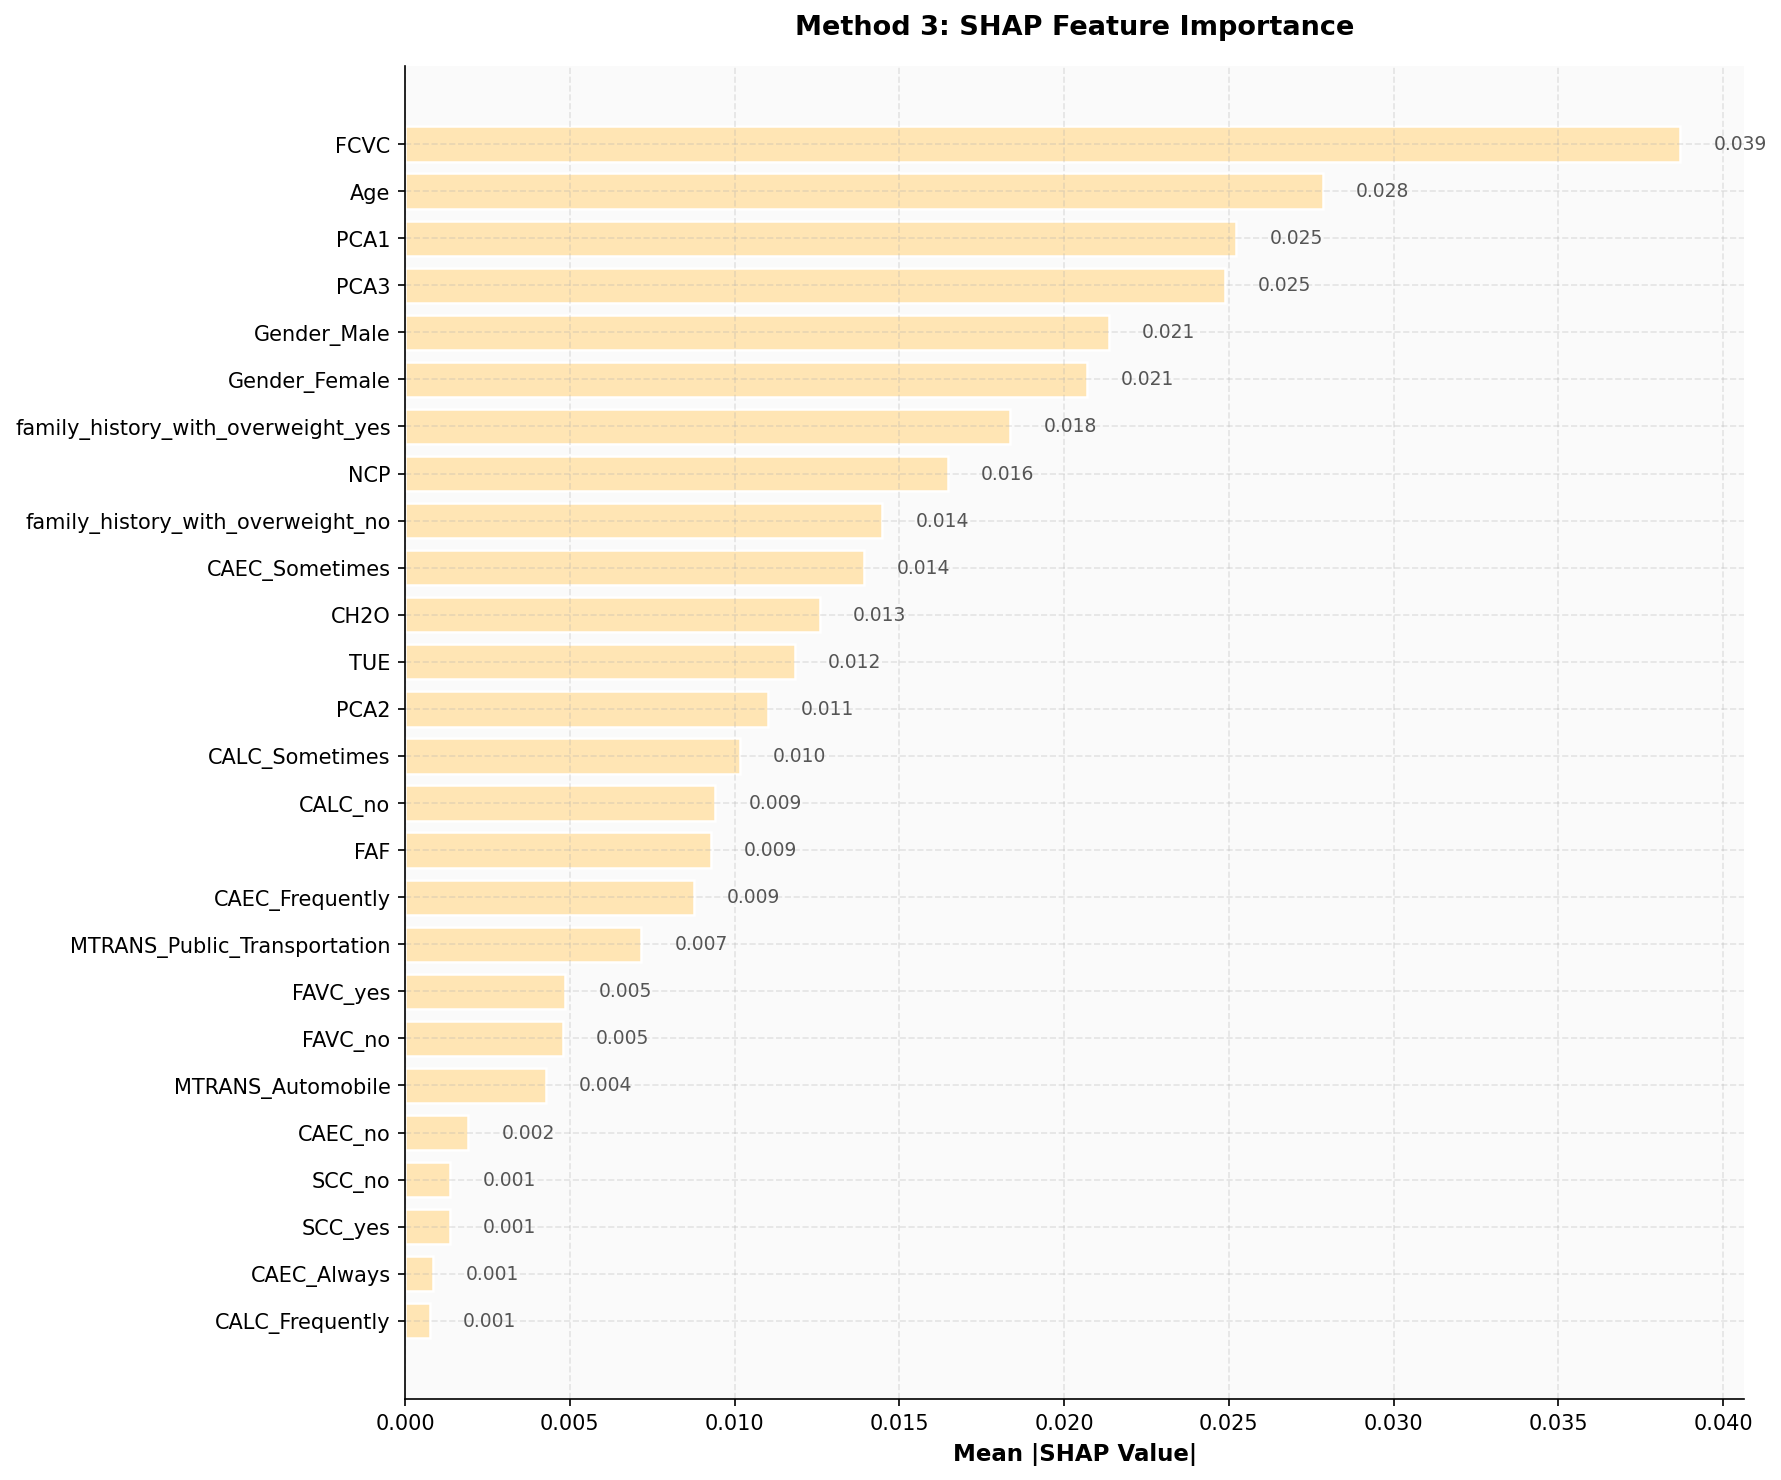

In [10]:
# SHAP Bar Plot (Pastel)
shap_sorted = shap_importance.sort_values('SHAP', ascending=True)

fig, ax = plt.subplots(figsize=(12, 10))

# Peach pastel gradient
colors = [plt.cm.Pastel1(0.1 + 0.6*i/len(shap_sorted)) for i in range(len(shap_sorted))]
bars = ax.barh(shap_sorted['Feature'], shap_sorted['SHAP'],
               color=PASTEL['peach'], edgecolor='white', height=0.75, linewidth=1.2)

ax.set_xlabel('Mean |SHAP Value|', fontweight='bold')
ax.set_title('Method 3: SHAP Feature Importance', pad=15)
ax.spines[['top', 'right']].set_visible(False)
ax.set_facecolor('#FAFAFA')

for bar, val in zip(bars, shap_sorted['SHAP']):
    ax.text(val + 0.001, bar.get_y() + bar.get_height()/2, f'{val:.3f}',
            va='center', fontsize=9, color='#555555')

plt.tight_layout()
plt.show()

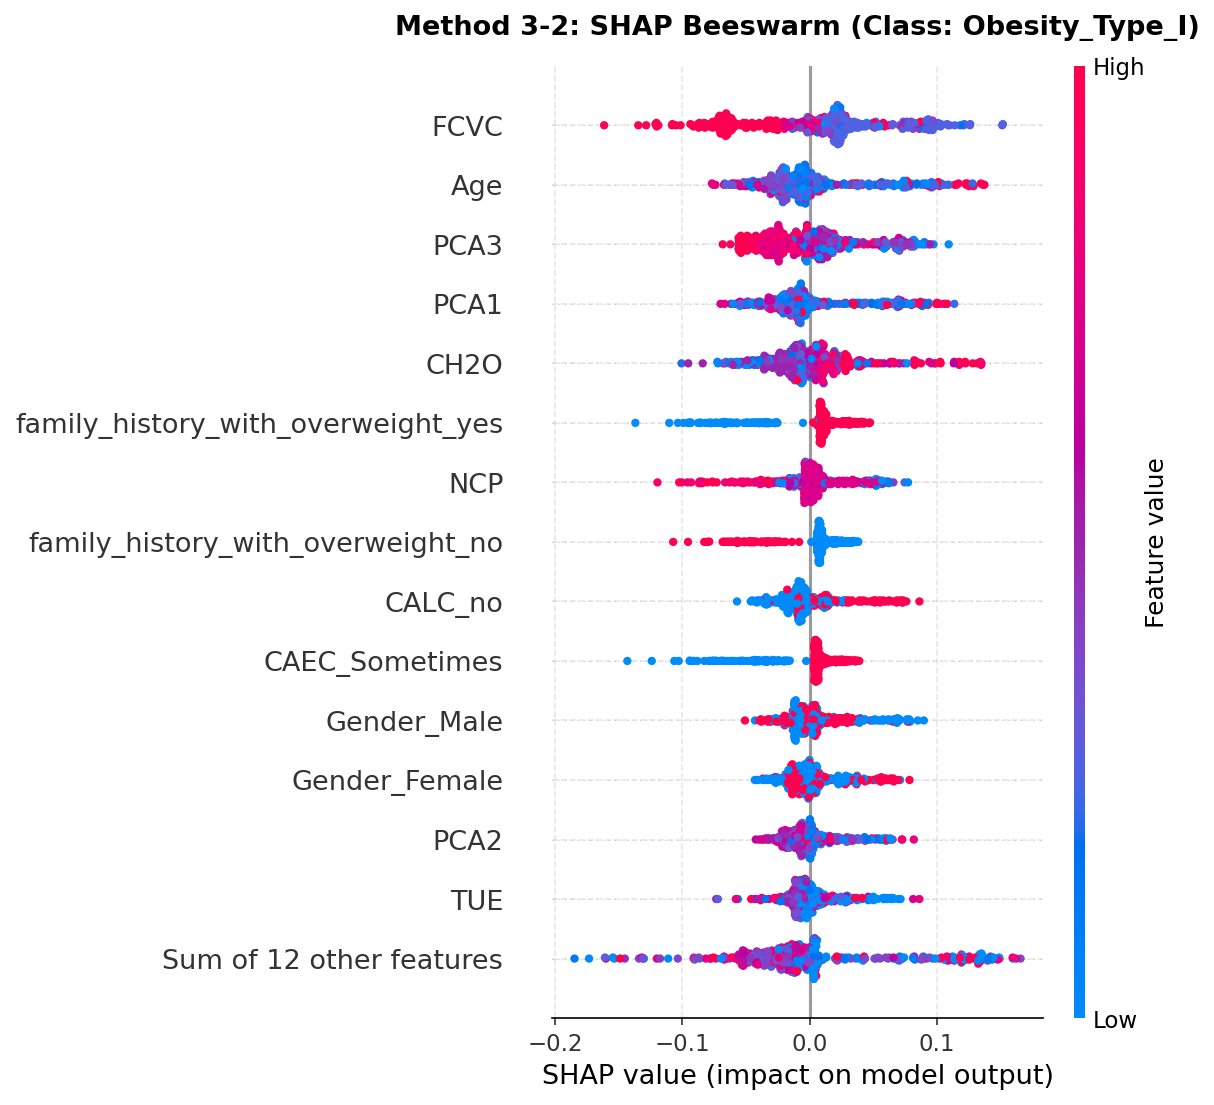

In [11]:
# SHAP Beeswarm (Most frequent class)
most_common = pd.Series(y).value_counts().index[0]

plt.figure(figsize=(12, 10))
shap.plots.beeswarm(shap_values[:, :, most_common], max_display=15, show=False)
plt.title(f'Method 3-2: SHAP Beeswarm (Class: {target_names[most_common]})', pad=15, fontweight='bold')
plt.tight_layout()
plt.show()

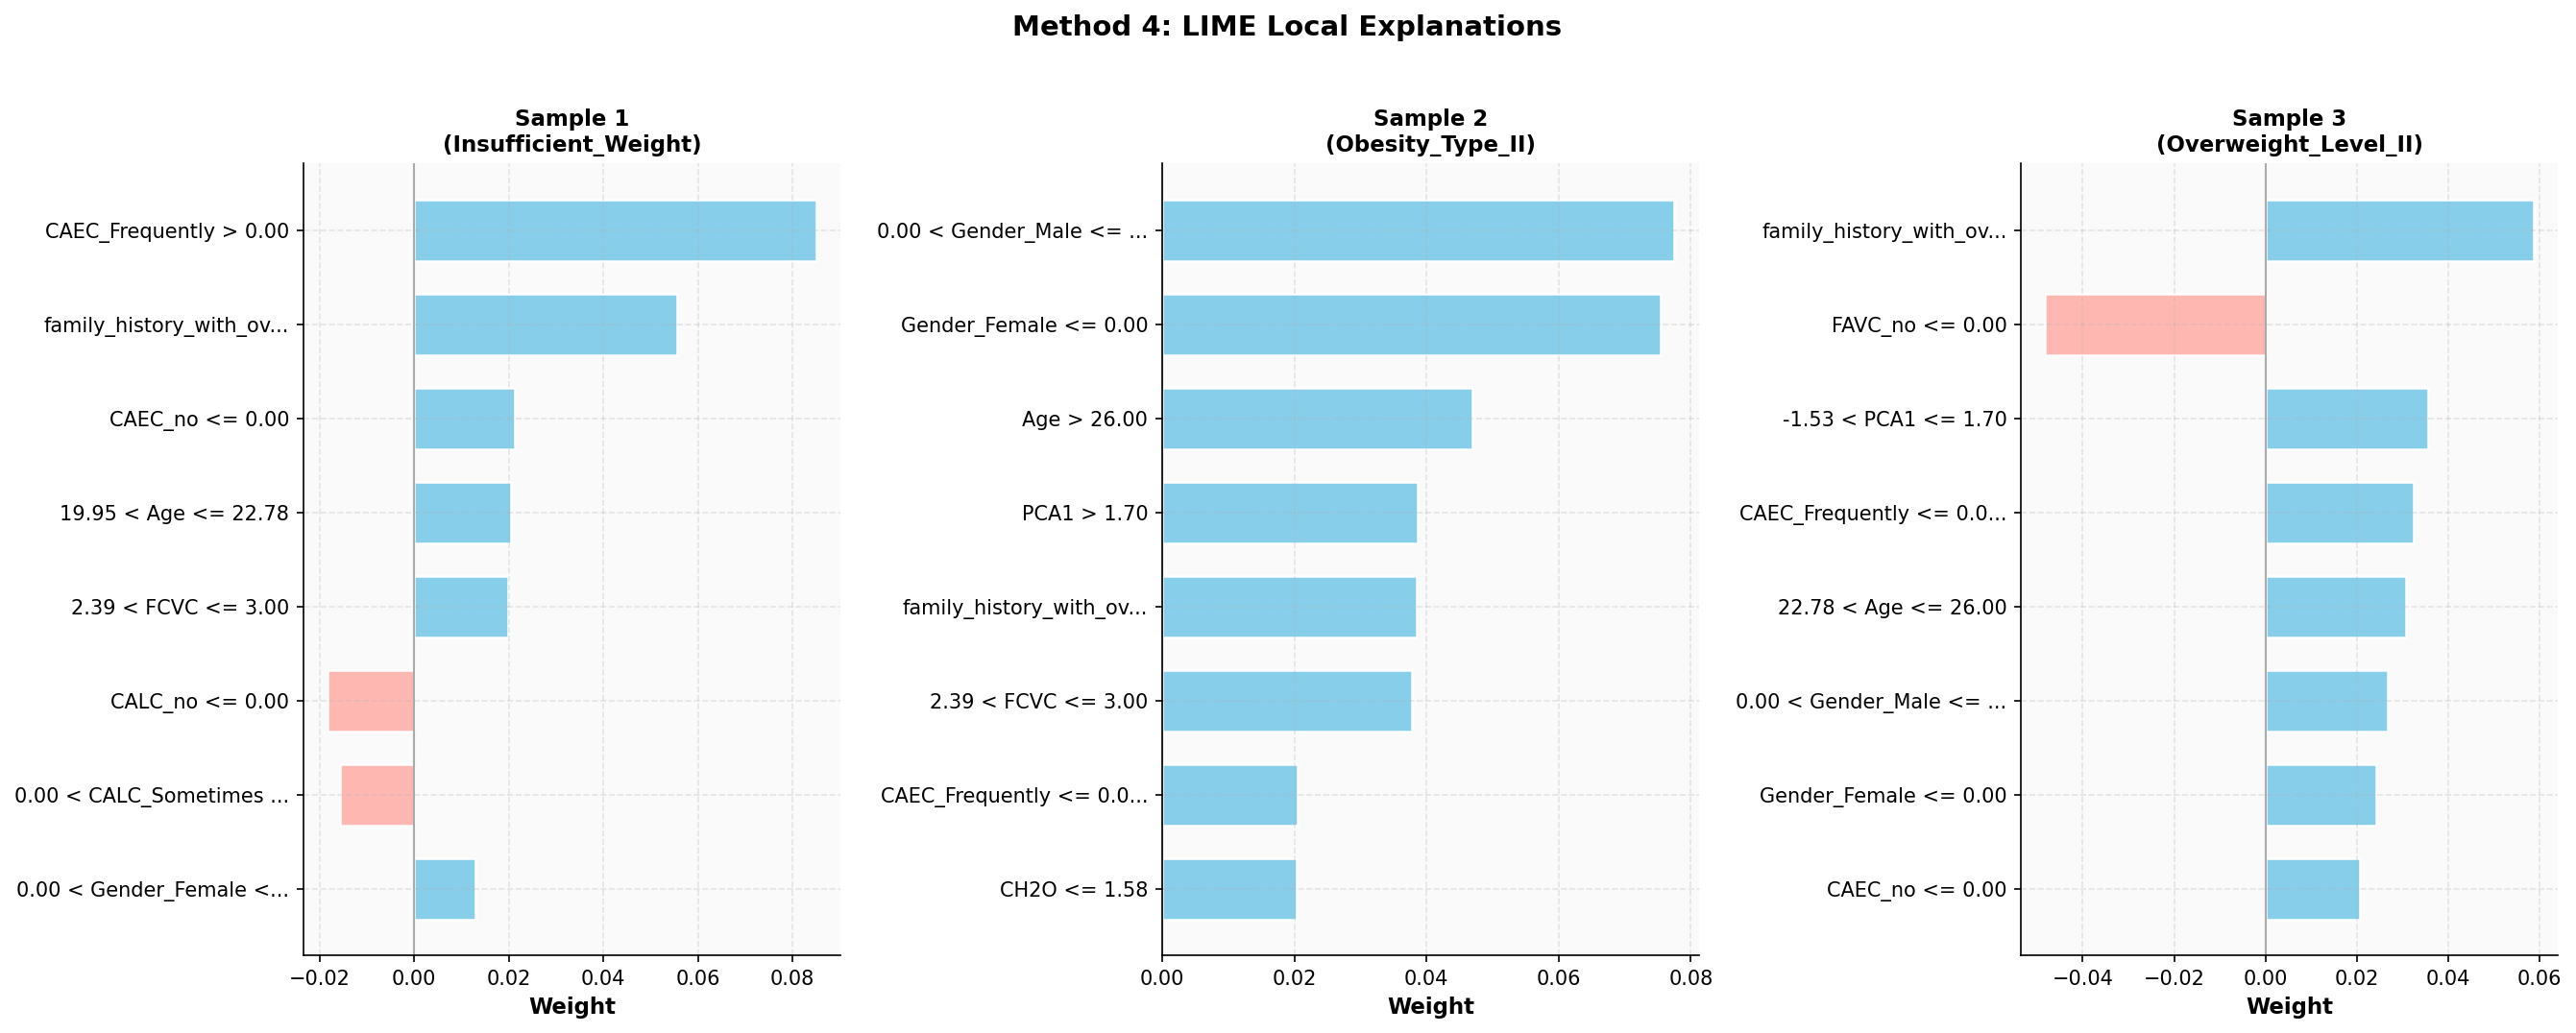

In [12]:
# Method 4: LIME
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X.values, feature_names=X.columns.tolist(), class_names=target_names.tolist(),
    mode='classification', random_state=42
)

# Explain 3 samples
sample_idx = [np.where(y == c)[0][0] for c in [0, len(target_names)//2, len(target_names)-1]]

fig, axes = plt.subplots(1, 3, figsize=(18, 7))

for i, idx in enumerate(sample_idx):
    exp = lime_explainer.explain_instance(X.iloc[idx].values, rf_model.predict_proba, num_features=8, top_labels=1)
    label = exp.available_labels()[0]
    exp_list = exp.as_list(label=label)

    features = [x[0][:22] + '...' if len(x[0]) > 22 else x[0] for x in exp_list]
    weights = [x[1] for x in exp_list]
    colors = [PASTEL['blue'] if w > 0 else PASTEL['coral'] for w in weights]

    axes[i].barh(features, weights, color=colors, edgecolor='white', height=0.65, linewidth=1.2)
    axes[i].axvline(0, color='#AAAAAA', linewidth=1, linestyle='-')
    axes[i].set_title(f'Sample {i+1}\n({target_names[y[idx]]})', fontsize=11, fontweight='bold')
    axes[i].spines[['top', 'right']].set_visible(False)
    axes[i].set_facecolor('#FAFAFA')
    axes[i].invert_yaxis()
    axes[i].set_xlabel('Weight', fontweight='bold')

plt.suptitle('Method 4: LIME Local Explanations', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [13]:
# LIME Aggregated Importance
np.random.seed(42)
lime_agg = {f: [] for f in X.columns}
for idx in np.random.choice(len(X), 50, replace=False):
    exp = lime_explainer.explain_instance(X.iloc[idx].values, rf_model.predict_proba, num_features=len(X.columns), top_labels=1)
    for feat_idx, weight in dict(exp.as_map()[exp.available_labels()[0]]).items():
        lime_agg[X.columns[feat_idx]].append(abs(weight))

lime_importance_df = pd.DataFrame({
    'Feature': list(lime_agg.keys()),
    'LIME': [np.mean(v) if v else 0 for v in lime_agg.values()]
}).sort_values('LIME', ascending=False)

print("LIME aggregated importance calculated")

LIME aggregated importance calculated


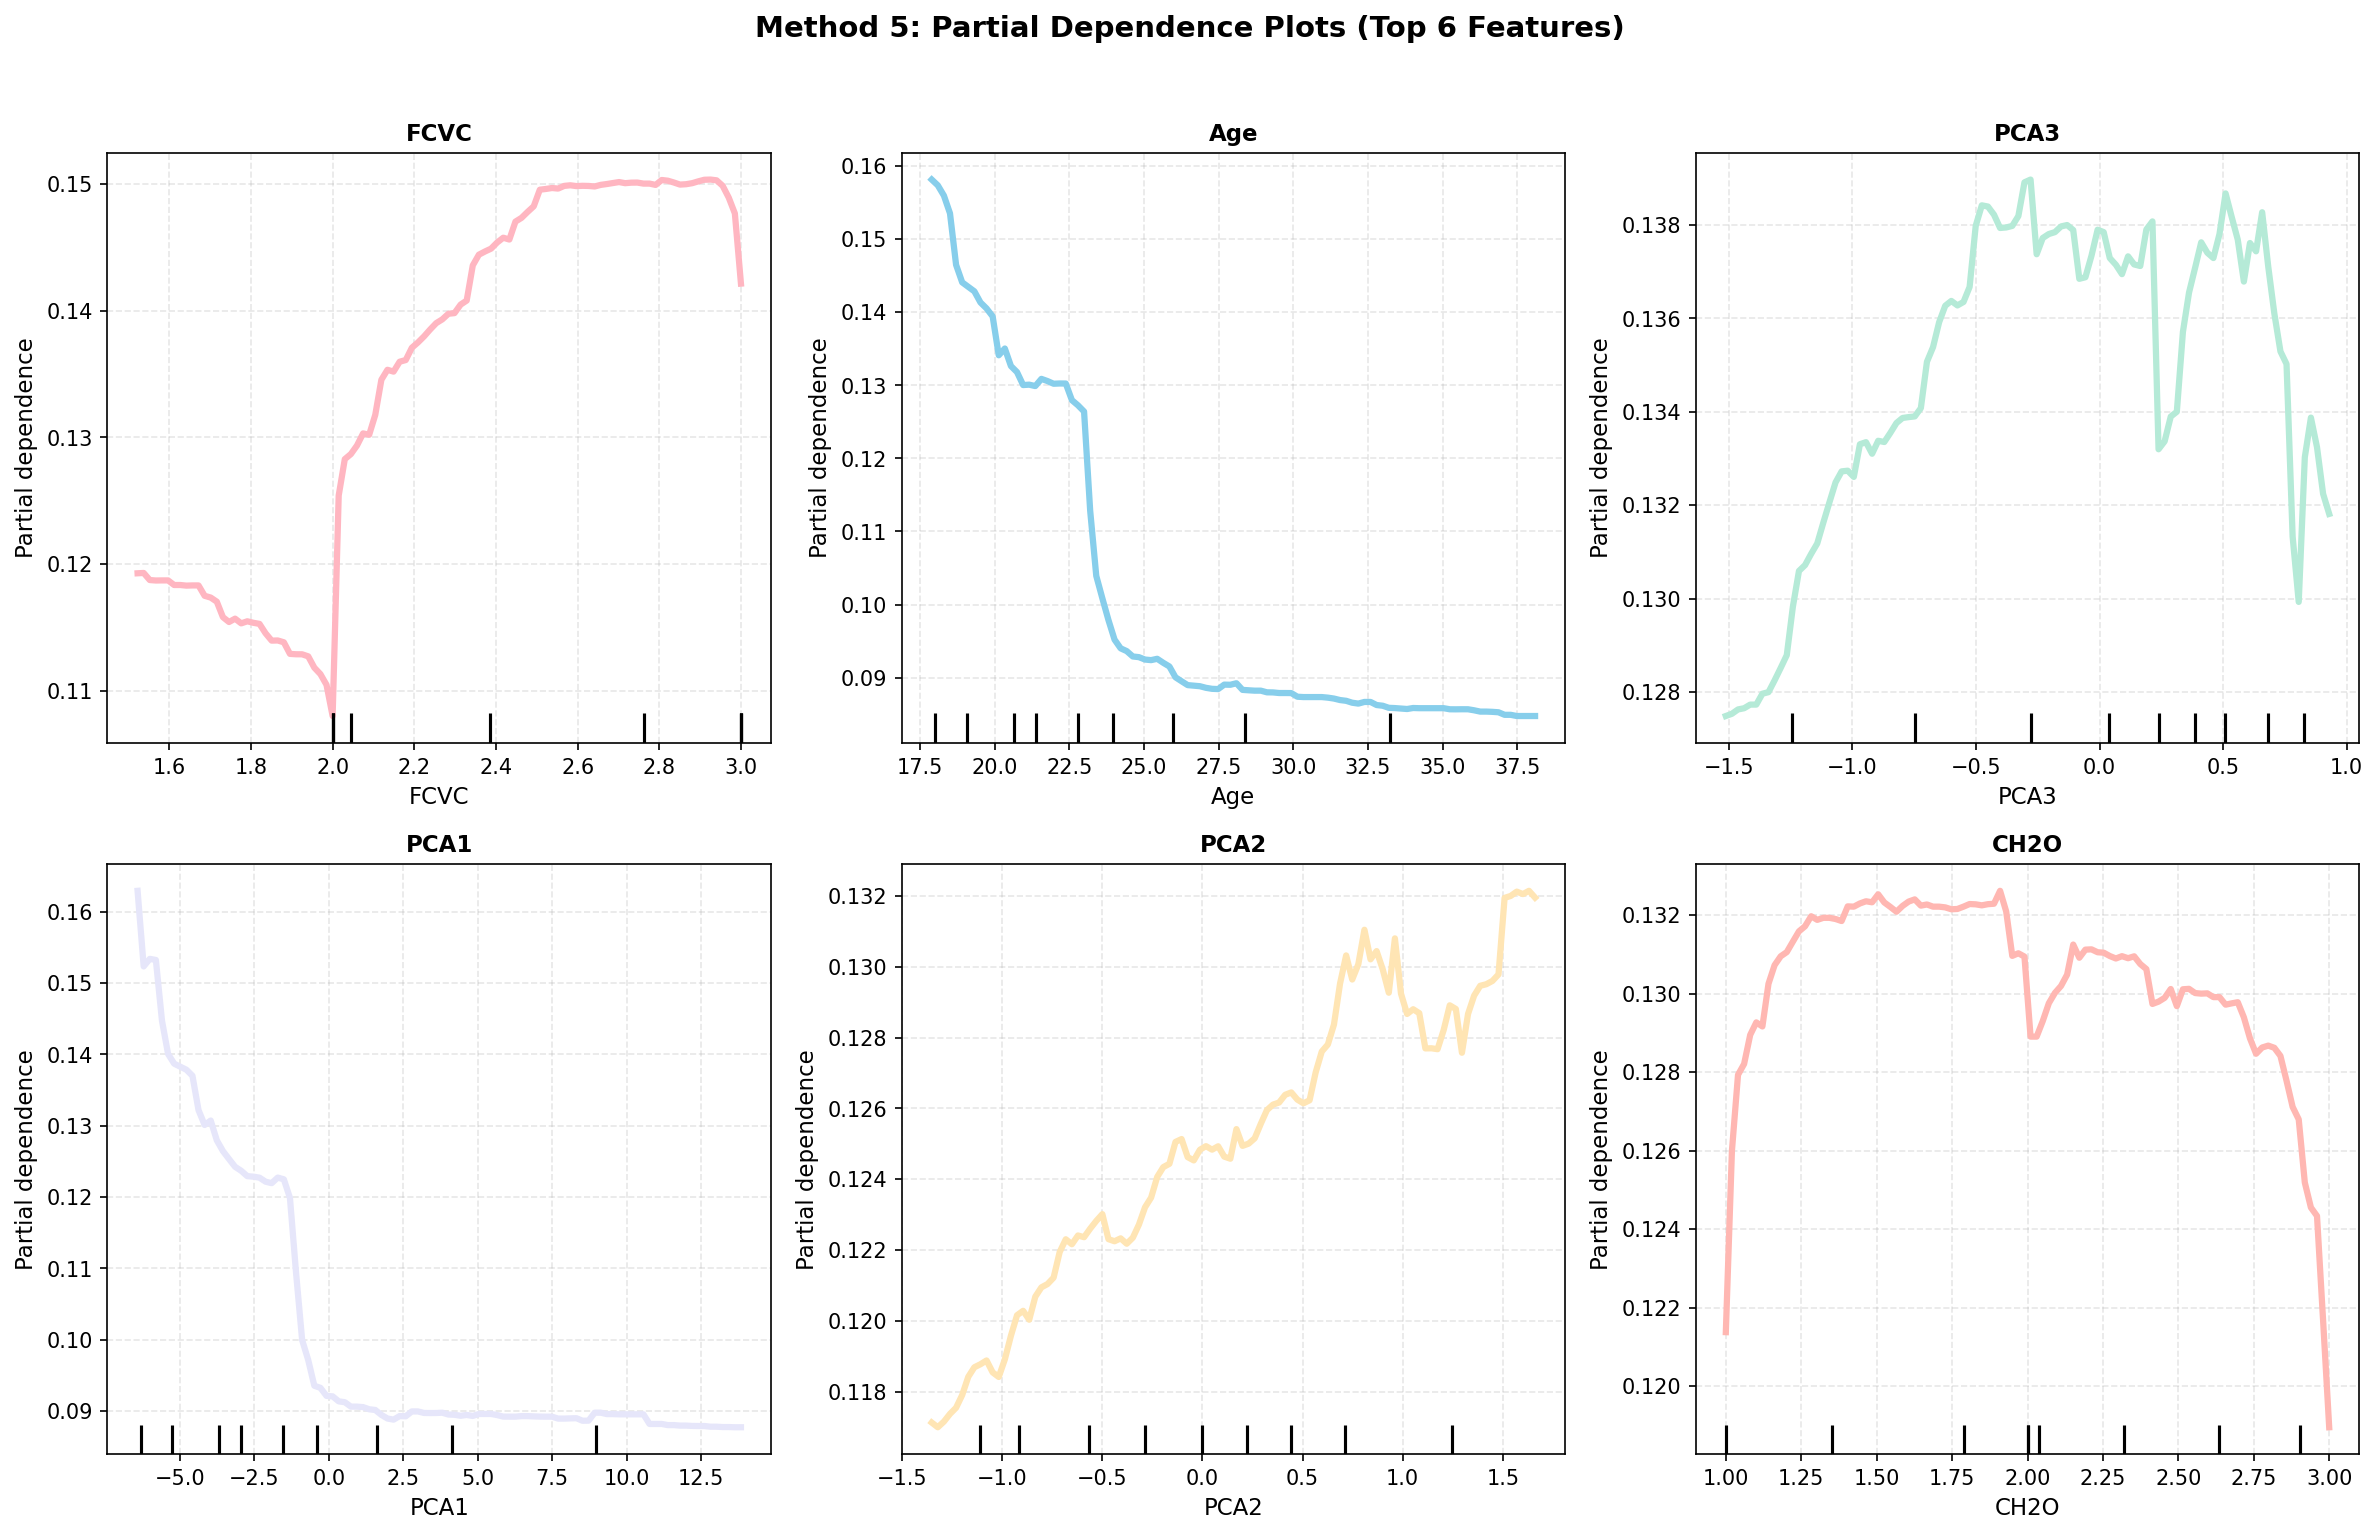

In [14]:
# Method 5: Partial Dependence Plot
top6 = feature_importance.tail(6)['Feature'].tolist()[::-1]

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
pastel_colors = [PASTEL['pink'], PASTEL['blue'], PASTEL['mint'],
                 PASTEL['lavender'], PASTEL['peach'], PASTEL['coral']]

for i, feat in enumerate(top6):
    ax = axes[i//3, i%3]
    feat_idx = X.columns.get_loc(feat)
    PartialDependenceDisplay.from_estimator(rf_model, X, [feat_idx], ax=ax, random_state=42,
                                            target=0,
                                            line_kw={'color': pastel_colors[i], 'linewidth': 3})
    ax.set_title(feat, fontsize=11, fontweight='bold')
    ax.spines[['top', 'right']].set_visible(False)
    ax.set_facecolor('#FAFAFA')

plt.suptitle('Method 5: Partial Dependence Plots (Top 6 Features)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 4-3. Results Comparison

In [15]:
# Create comparison table
comparison = pd.DataFrame({'Feature': X.columns})
comparison = comparison.merge(feature_importance.rename(columns={'Importance': 'RF'}), on='Feature')
comparison = comparison.merge(perm_importance_df[['Feature', 'Importance']].rename(columns={'Importance': 'Perm'}), on='Feature')
comparison = comparison.merge(shap_importance.rename(columns={'SHAP': 'SHAP'}), on='Feature')
comparison = comparison.merge(lime_importance_df.rename(columns={'LIME': 'LIME'}), on='Feature')

# Normalize
for col in ['RF', 'Perm', 'SHAP', 'LIME']:
    comparison[f'{col}_N'] = (comparison[col] - comparison[col].min()) / (comparison[col].max() - comparison[col].min() + 1e-10)

comparison['Avg'] = comparison[['RF_N', 'Perm_N', 'SHAP_N', 'LIME_N']].mean(axis=1)
comparison = comparison.sort_values('Avg', ascending=False)

# Calculate ranks
for col in ['RF', 'Perm', 'SHAP', 'LIME']:
    comparison[f'{col}_R'] = comparison[col].rank(ascending=False).astype(int)
comparison['Avg_R'] = comparison[['RF_R', 'Perm_R', 'SHAP_R', 'LIME_R']].mean(axis=1)

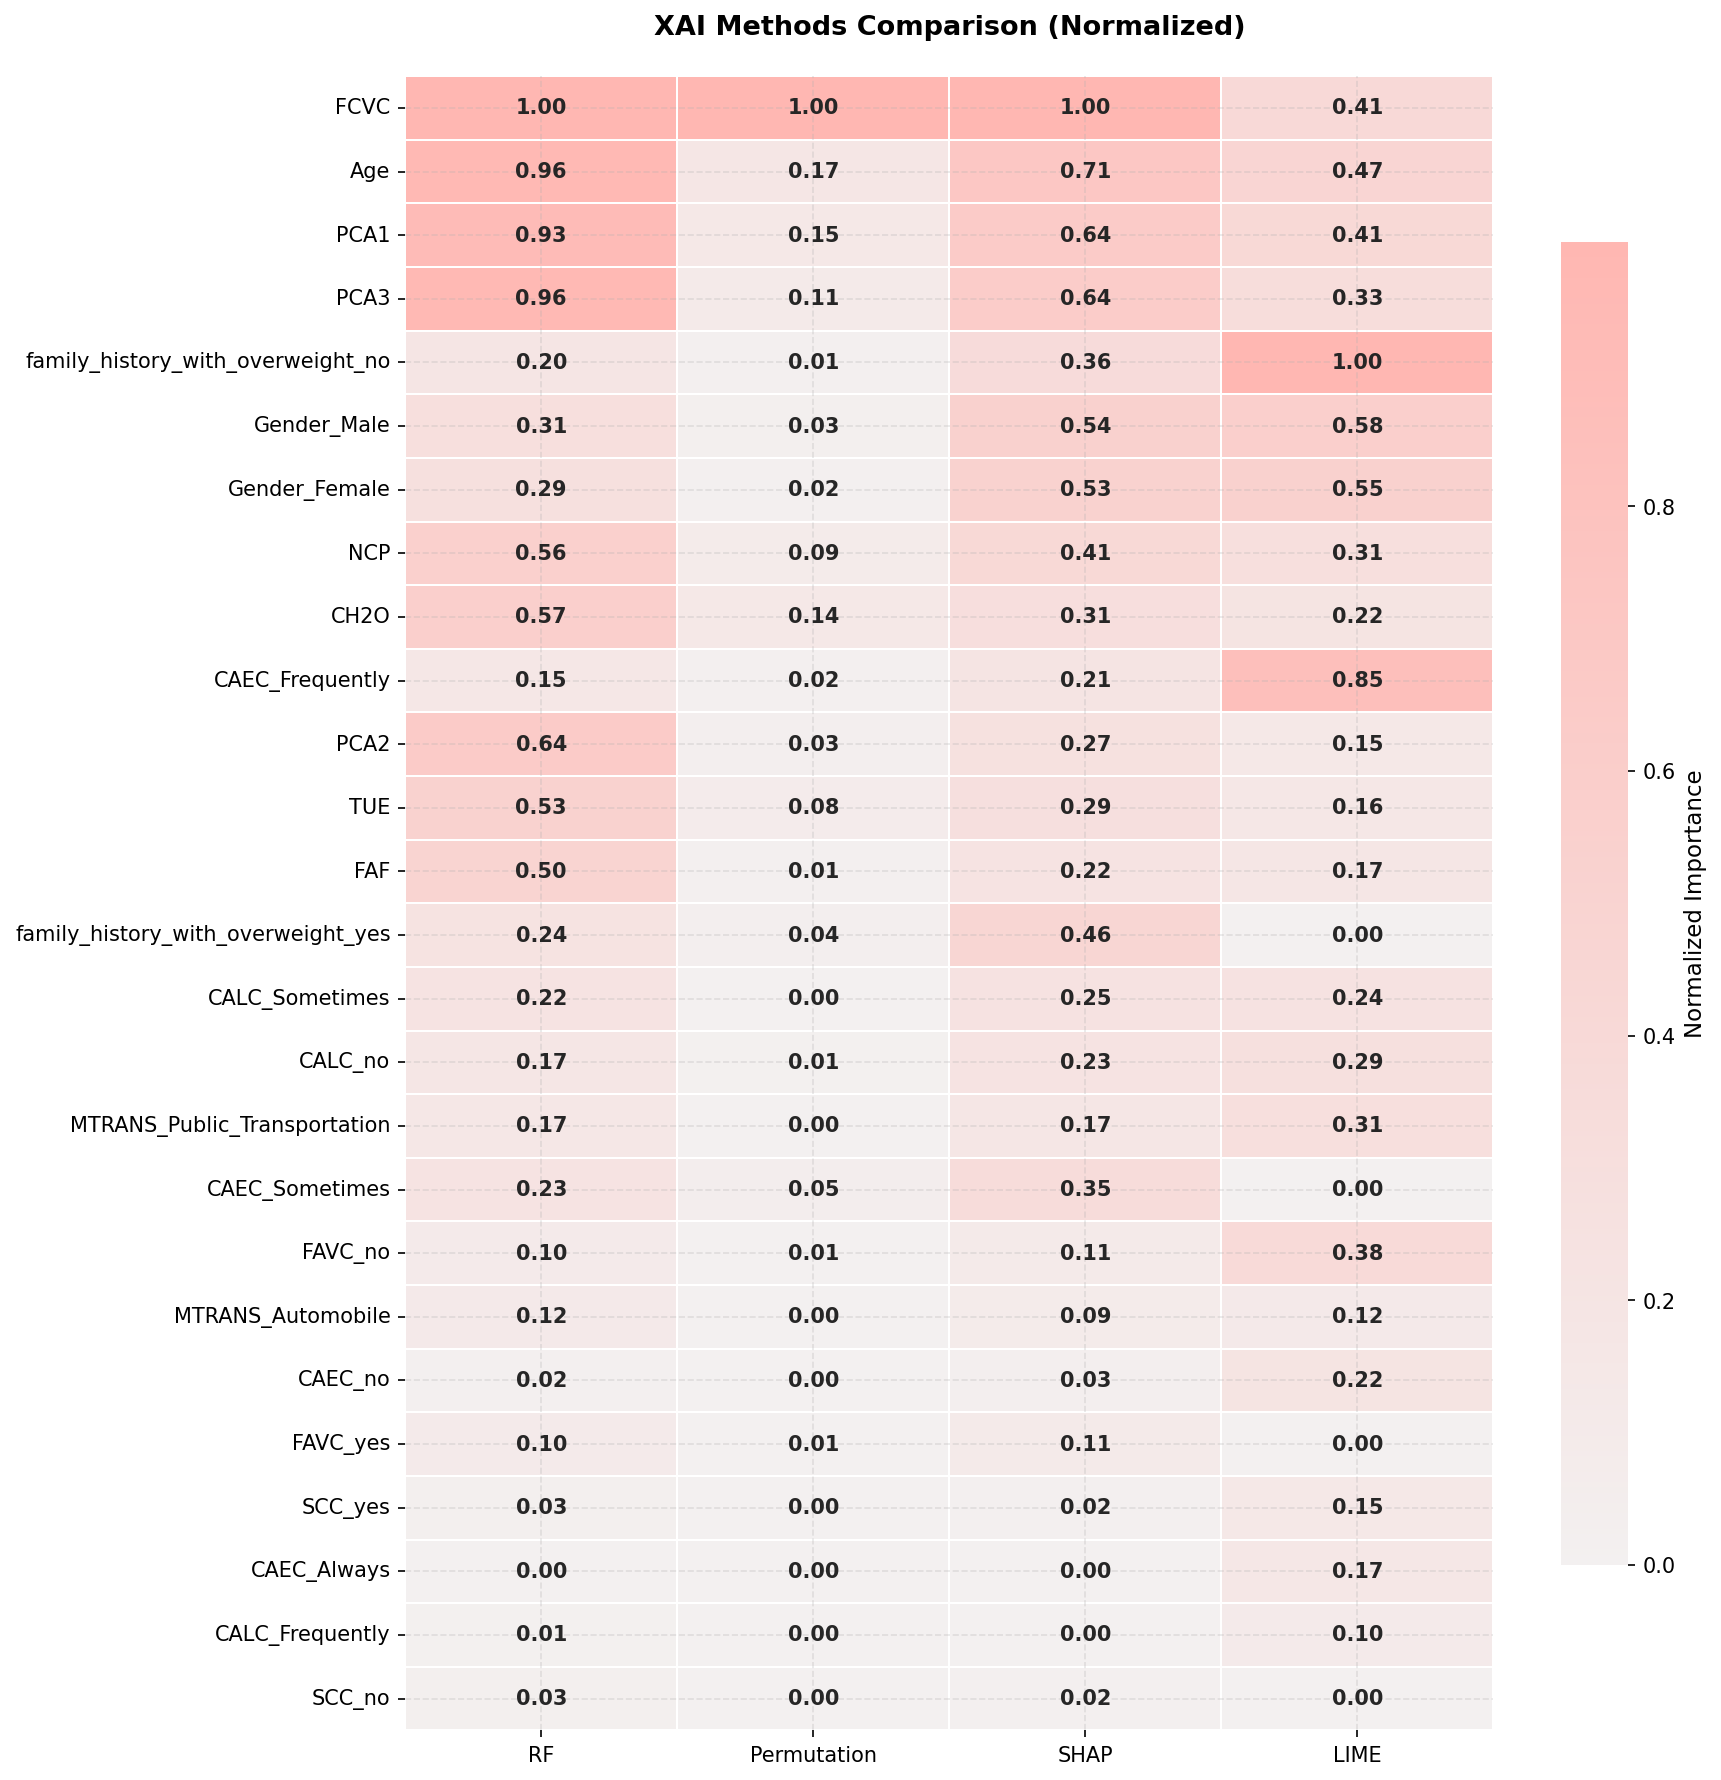

In [16]:
# Heatmap (Pastel)
fig, ax = plt.subplots(figsize=(12, 12))
heatmap_data = comparison[['RF_N', 'Perm_N', 'SHAP_N', 'LIME_N']].values

# Custom pastel colormap
cmap = sns.light_palette(PASTEL['coral'], as_cmap=True)

sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap=cmap,
            xticklabels=['RF', 'Permutation', 'SHAP', 'LIME'],
            yticklabels=comparison['Feature'].values, ax=ax,
            linewidths=0.8, linecolor='white',
            annot_kws={'size': 10, 'weight': 'bold'},
            cbar_kws={'label': 'Normalized Importance', 'shrink': 0.8})

ax.set_title('XAI Methods Comparison (Normalized)', pad=20, fontweight='bold')
ax.set_facecolor('#FAFAFA')
plt.tight_layout()
plt.show()

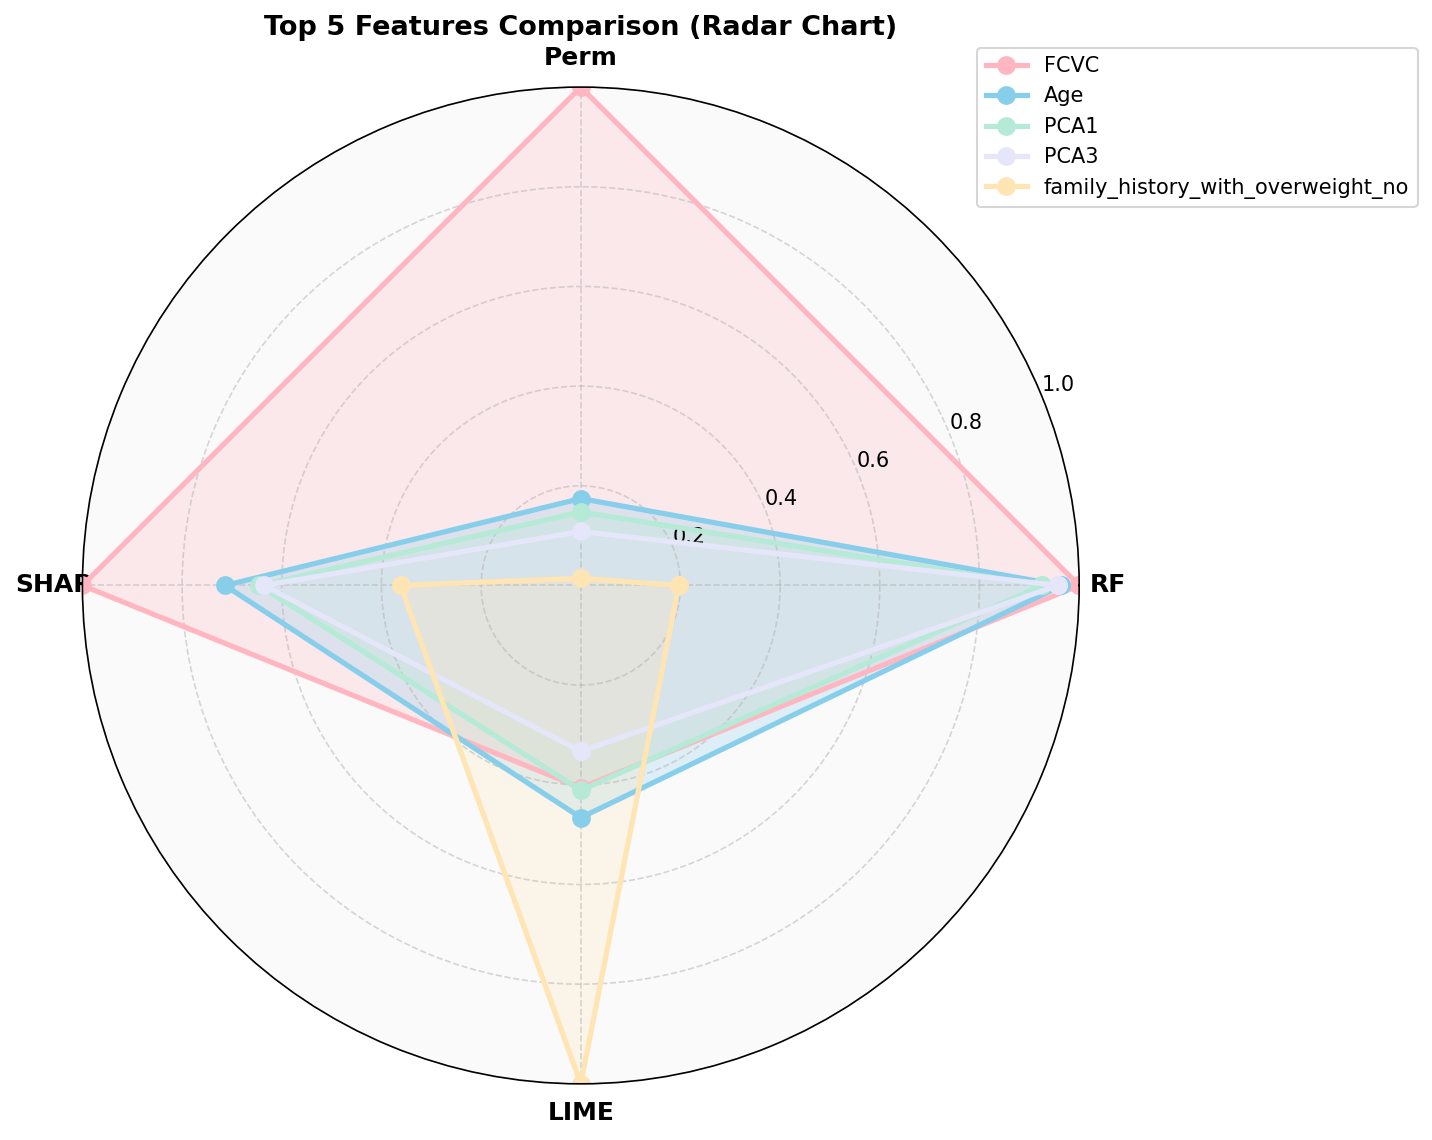

In [17]:
# Radar Chart - Top 5 (Pastel)
from math import pi

top5 = comparison.head(5)
categories = ['RF', 'Perm', 'SHAP', 'LIME']
angles = [n / 4 * 2 * pi for n in range(4)] + [0]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
ax.set_facecolor('#FAFAFA')

pastel_radar = [PASTEL['pink'], PASTEL['blue'], PASTEL['mint'], PASTEL['lavender'], PASTEL['peach']]

for i, (_, row) in enumerate(top5.iterrows()):
    values = [row['RF_N'], row['Perm_N'], row['SHAP_N'], row['LIME_N'], row['RF_N']]
    ax.plot(angles, values, 'o-', linewidth=2.5, label=row['Feature'], color=pastel_radar[i], markersize=8)
    ax.fill(angles, values, alpha=0.25, color=pastel_radar[i])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12, fontweight='bold')
ax.set_ylim(0, 1)
ax.legend(loc='upper right', bbox_to_anchor=(1.35, 1.05), fontsize=10)
ax.set_title('Top 5 Features Comparison (Radar Chart)', fontsize=13, fontweight='bold', pad=25)

# Style grid
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [18]:
# Ranking Table
print("\n" + "="*90)
print("                         XAI Feature Ranking Comparison")
print("="*90)
print(f"{'Rank':<5} {'Feature':<32} {'RF':>6} {'Perm':>6} {'SHAP':>6} {'LIME':>6} {'Avg':>8}")
print("-"*90)

rank_sorted = comparison.sort_values('Avg_R')
for i, (_, row) in enumerate(rank_sorted.iterrows(), 1):
    print(f"{i:<5} {row['Feature']:<32} {row['RF_R']:>6} {row['Perm_R']:>6} {row['SHAP_R']:>6} {row['LIME_R']:>6} {row['Avg_R']:>8.1f}")

print("="*90)


                         XAI Feature Ranking Comparison
Rank  Feature                              RF   Perm   SHAP   LIME      Avg
------------------------------------------------------------------------------------------
1     FCVC                                  1      1      1      7      2.5
2     Age                                   2      2      2      5      2.8
3     PCA1                                  4      3      3      6      4.0
4     PCA3                                  3      5      4      9      5.2
5     Gender_Male                          10     11      5      3      7.2
6     NCP                                   7      6      8     11      8.0
7     Gender_Female                        11     12      6      4      8.2
8     CH2O                                  6      4     11     15      9.0
9     family_history_with_overweight_no     15     14      9      1      9.8
10    TUE                                   8      7     12     18     11.2
11    PCA2     

## 4-4. Summary

In [19]:
print("\n" + "="*60)
print("                    FINAL SUMMARY")
print("="*60)
print(f"\n  Model: Random Forest (n_estimators=128)")
print(f"  Accuracy: {accuracy:.2%}")
print(f"  Features: {X.shape[1]} | Samples: {len(y)}")
print(f"\n  XAI Methods: RF, Permutation, SHAP, LIME, PDP")
print(f"\n  Top 5 Features (Consensus):")
for i, (_, row) in enumerate(rank_sorted.head(5).iterrows(), 1):
    print(f"    {i}. {row['Feature']} (Avg Rank: {row['Avg_R']:.1f})")
print("\n" + "="*60)


                    FINAL SUMMARY

  Model: Random Forest (n_estimators=128)
  Accuracy: 100.00%
  Features: 26 | Samples: 2111

  XAI Methods: RF, Permutation, SHAP, LIME, PDP

  Top 5 Features (Consensus):
    1. FCVC (Avg Rank: 2.5)
    2. Age (Avg Rank: 2.8)
    3. PCA1 (Avg Rank: 4.0)
    4. PCA3 (Avg Rank: 5.2)
    5. Gender_Male (Avg Rank: 7.2)



In [20]:
# Save results
comparison.to_csv('xai_results.csv', index=False)
print("Results saved: xai_results.csv")

from google.colab import files
files.download('xai_results.csv')

Results saved: xai_results.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>